In [14]:
# for data input and output:
import numpy as np
import os

# for deep learning:
import keras
from keras.models import Model
from keras.layers import Input, Dense, Conv2D, Dropout
from keras.layers import BatchNormalization, Flatten
from keras.layers import Activation
from keras.layers import Reshape  # new!
from keras.layers import Conv2DTranspose, UpSampling2D  # new!
from tensorflow.keras.optimizers import RMSprop

# for plotting:
import pandas as pd
from matplotlib import pyplot as plt
% matplotlib inline

AttributeError: module 'keras.utils.generic_utils' has no attribute 'populate_dict_with_module_objects'

In [9]:
path2 = r'C:\Users\henri\dsci478k\data\monet_jpg'

imgs= []
for img in os.listdir(path2):
    pic = cv2.imread(os.path.join(path2,img))
    pic = cv2.cvtColor(pic,cv2.COLOR_BGR2RGB)
    pic = cv2.resize(pic,(28,28))
    imgs.append([pic])

In [10]:
data = np.reshape(imgs,(len(imgs),28,28,3))

print(data.shape)

img_w,img_h = data.shape[1:3]

(300, 28, 28, 3)


In [11]:
for i in range(49):
    # define subplot
    plt.subplot(7, 7, 1 + i)
    # turn off axis
    plt.axis('off')
    # plot raw pixel data
    plt.imshow(data[i])
plt.show()

NameError: name 'plt' is not defined

In [3]:
def build_discriminator(depth=256, p=0.4):

    # Define inputs
    image = Input((img_w,img_h,3))

    # Convolutional layers
    conv1 = Conv2D(depth*1, 5, strides=2,
                   padding='same', activation='relu')(image)
    conv1 = Dropout(p)(conv1)

    conv2 = Conv2D(depth*2, 5, strides=2,
                   padding='same', activation='relu')(conv1)
    conv2 = Dropout(p)(conv2)

    conv3 = Conv2D(depth*4, 5, strides=2,
                   padding='same', activation='relu')(conv2)
    conv3 = Dropout(p)(conv3)

    conv4 = Conv2D(depth*8, 5, strides=1,
                   padding='same', activation='relu')(conv3)
    conv4 = Flatten()(Dropout(p)(conv4))

    # Output layer
    prediction = Dense(1, activation='sigmoid')(conv4)

    # Model definition
    model = Model(inputs=image, outputs=prediction)

    return model

In [4]:
discriminator = build_discriminator()

NameError: name 'Input' is not defined

In [5]:
discriminator.summary()

NameError: name 'discriminator' is not defined

In [114]:
discriminator.compile(loss='binary_crossentropy',
                      optimizer=RMSprop(learning_rate=0.0008,
                                        decay=6e-8,
                                        clipvalue=1.0),
                      metrics=['accuracy'])

In [115]:
z_dimensions = 32

In [116]:
def build_generator(latent_dim=z_dimensions,
                    depth=64, p=0.4):

    # Define inputs
    noise = Input((latent_dim,))

    # First dense layer
    dense1 = Dense(7*7*depth)(noise)
    dense1 = BatchNormalization(momentum=0.9)(dense1) # default momentum for moving average is 0.99
    dense1 = Activation(activation='relu')(dense1)
    dense1 = Reshape((7,7,depth))(dense1)
    dense1 = Dropout(p)(dense1)

    # De-Convolutional layers
    conv1 = UpSampling2D()(dense1)
    conv1 = Conv2DTranspose(int(depth/2),
                            kernel_size=5, padding='same',
                            activation=None,)(conv1)
    conv1 = BatchNormalization(momentum=0.9)(conv1)
    conv1 = Activation(activation='relu')(conv1)

    conv2 = UpSampling2D()(conv1)
    conv2 = Conv2DTranspose(int(depth/4),
                            kernel_size=5, padding='same',
                            activation=None,)(conv2)
    conv2 = BatchNormalization(momentum=0.9)(conv2)
    conv2 = Activation(activation='relu')(conv2)

    conv3 = Conv2DTranspose(int(depth/8),
                            kernel_size=5, padding='same',
                            activation=None,)(conv2)
    conv3 = BatchNormalization(momentum=0.9)(conv3)
    conv3 = Activation(activation='relu')(conv3)

    # Output layer
    image = Conv2D(3, kernel_size=5, padding='same',
                   activation='sigmoid')(conv3)

    # Model definition
    model = Model(inputs=noise, outputs=image)

    return model

In [117]:
generator = build_generator()

In [118]:
generator.summary()

Model: "model_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_5 (InputLayer)        [(None, 32)]              0         
                                                                 
 dense_3 (Dense)             (None, 3136)              103488    
                                                                 
 batch_normalization_4 (Batc  (None, 3136)             12544     
 hNormalization)                                                 
                                                                 
 activation_4 (Activation)   (None, 3136)              0         
                                                                 
 reshape_1 (Reshape)         (None, 7, 7, 64)          0         
                                                                 
 dropout_9 (Dropout)         (None, 7, 7, 64)          0         
                                                           

In [119]:
z = Input(shape=(z_dimensions,))
img = generator(z)
discriminator.trainable = False
pred = discriminator(img)
adversarial_model = Model(z, pred)
adversarial_model.compile(loss='binary_crossentropy',
                          optimizer=RMSprop(lr=0.0004,
                                            decay=3e-8,
                                            clipvalue=1.0),
                          metrics=['accuracy'])

In [132]:
def train(epochs=2000, batch=128, z_dim=z_dimensions):

    d_metrics = []
    a_metrics = []

    running_d_loss = 0
    running_d_acc = 0
    running_a_loss = 0
    running_a_acc = 0

    for i in range(epochs):

        # sample real images:
        real_imgs = np.reshape(
            data[np.random.choice(data.shape[0],
                                  batch,
                                  replace=False)],
            (batch,28,28,3))

        # generate fake images:
        fake_imgs = generator.predict(
            np.random.uniform(-1.0, 1.0,
                              size=[batch, z_dim]))

        # concatenate images as discriminator inputs:
        x = np.concatenate((real_imgs,fake_imgs))

        # assign y labels for discriminator:
        y = np.ones([2*batch,1])
        y[batch:,:] = 0

        # train discriminator:
        d_metrics.append(
            discriminator.train_on_batch(x,y)
        )
        running_d_loss += d_metrics[-1][0]
        running_d_acc += d_metrics[-1][1]

        # adversarial net's noise input and "real" y:
        noise = np.random.uniform(-1.0, 1.0,
                                  size=[batch, z_dim])
        y = np.ones([batch,1])

        # train adversarial net:
        a_metrics.append(
            adversarial_model.train_on_batch(noise,y)
        )
        running_a_loss += a_metrics[-1][0]
        running_a_acc += a_metrics[-1][1]

        # periodically print progress & fake images:
        if (i+1)%100 == 0:

            print('Epoch #{}'.format(i))
            log_mesg = "%d: [D loss: %f, acc: %f]" % \
                       (i, running_d_loss/i, running_d_acc/i)
            log_mesg = "%s  [A loss: %f, acc: %f]" % \
                       (log_mesg, running_a_loss/i, running_a_acc/i)
            print(log_mesg)

            noise = np.random.uniform(-1.0, 1.0,
                                      size=[16, z_dim])
            gen_imgs = generator.predict(noise)

            plt.figure(figsize=(5,5))

            for k in range(gen_imgs.shape[0]):
                plt.subplot(4, 4, k+1)
                plt.imshow(gen_imgs[k, :, :, 0])
                plt.axis('off')

            plt.tight_layout()
            plt.show()
            return a_metrics, d_metrics

Epoch #99
99: [D loss: 0.121102, acc: 0.993450]  [A loss: 2.489059, acc: 0.029356]


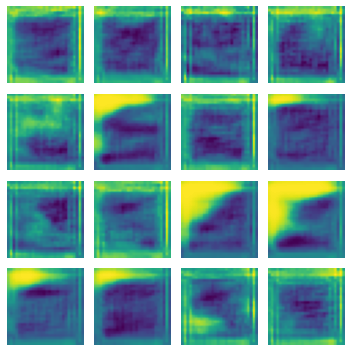

In [133]:
a_metrics_complete, d_metrics_complete = train()